In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
from utils import *
from plots import plot_locality_hist, plot_locality_kde

# Read results from ../results/locality, output data to ../out/figures/locality
BASE_DATA_PATH = os.path.join("..", "out", "locality")
OUTPUT_FOLDER = os.path.join("..", "out", "figures", "locality")
print("Reading data from: ", BASE_DATA_PATH)
print("Outputting plots to: ", OUTPUT_FOLDER)
set_default_style()

Reading data from:  ../out/locality
Outputting plots to:  ../out/figures/locality


# Visualizaciones de localidad con histogramas
Idea: dada una búsqueda sobre un centro $p_i$ que encuentra un número de puntos en el vecindario $p_j$, construimos un histograma con las distancias $|i-j|$, y lo ponemos en un dataset (distancia, count).

Las búsquedas fueron $k$-NN y acumulando sobre todos los puntos de la nube como centro. Para radio fijo se encuentran resultados similares, solo que con la dificultad añadida de tener que ajustar el radio para compensar la densidad del dataset.



## Ajustes para poder visualizar el histograma

Tuve que hacer algunos ajustes para que se viera bien el efecto de la distancia en la localidad de la nube:

- En primer lugar comprimí el histograma en bins y tomé la distancia más baja para representar el bin, por ejemplo si $bin\_size=2$, se convierte (dist=1, count = 100 / dist=2, count = 200 / dist=3, count=300 / dist=4, count=75) en (dist=1, count=300 / dist=3, count=375), ver función `bin_datasets`.

- En segundo lugar, para que los outliers no afectaran mucho a la representación, añadí un límite superior $x_{max}$ (`max_dist` en el código) a las distancias. El límite se toma como el máximo de los límites $x_{max,ord}$ de cada reordenación (none, mort, hilb) bajo el que se encuentran el $p\%$ de los datos, ver función `compute_max_dists`.

Los parámetros que tomé fueron $k = 50$, $bin\_size = 100$ y $p = 0.99$. Así ya salen gráficas, sin embargo, encontré algo bastante curioso con esto. El problema es que los puntos encontrados en distancias bajas del punto de búsqueda son la gran mayoría, y en muchos datasets el orden original es bastante bueno en el sentido de que existen más datos en el rango bajo. 

Sin embargo ese rango bajo es ignorable para el rendimiento ya que debería generar muy pocos fallos caché comparando con el rango de distancias altas. Por lo tanto, también añadí un límite inferior $x_{min}$ al gráfico (`min_dist` en el código), que puse a $1000$ de momento. 

Una vez hecho esto, se nota en muchos datasets como al no reordenar la nube existe una gran cantidad de picos aislados en distancias alejadas de memoria, lo cuál interpreto como una versión suavizada de los picos extremos que se encontrarían al hacer esto para una nube regular de puntos enteros $(i,j,k)$ creada con un triple bucle sencillo.

### KDE-plot

Quizás menos informativo que el histograma ya que no se ven los picos, pero se ve rápidamente como la distribución de las distancias (dentro de los límites $x_{min}, x_{max}$) mejora al reordenar la nube. 

También añadí el cálculo rápido de la media y la desviación típica de las distancias, con el dataset original sin bins y sin límites.

In [24]:
import pandas as pd
import numpy as np

# 1. Define the Unification Mapping
ENCODER_MAPPING = {
    "NoEncoding": "none",
    "MortonEncoder3D": "mort",
    "HilbertEncoder3D": "hilb"
}
CLOUDS_DATASETS = {
    "Lille_0": "Paris_Lille",
    "Paris_Luxembourg_6": "Paris_Lille",
    "5080_54400": "DALES",
    "sg27_station8_intensity_rgb": "Semantic3D",
    "station1_xyz_intensity_rgb": "Semantic3D",
}

def get_weighted_quartiles(values, weights):
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]
    cumulative_weight = np.cumsum(weights) - 0.5 * weights
    cumulative_weight /= np.sum(weights)
    return np.interp([0.25, 0.5, 0.75], cumulative_weight, values) 

# 2. Updated locality stats function with naming unification
def compute_locality_stats(datasets):
    stats = []
    for raw_encoder_name, df in datasets.items():
        # Unify name to shorthand
        encoder_name = ENCODER_MAPPING.get(raw_encoder_name, raw_encoder_name)
        
        dist = df["distance"].values
        counts = df["count"].values
        n = np.sum(counts)
        
        # Basic Weighted Stats
        mean = np.average(dist, weights=counts)
        std_dev = np.sqrt(np.average((dist - mean)**2, weights=counts))
        
        # Weighted Quartiles
        q1, q2, q3 = get_weighted_quartiles(dist, counts)
        
        # Moment-based skewness
        third_moment = np.average((dist - mean)**3, weights=counts)
        if std_dev > 0:
            m3_skew = third_moment / (std_dev**3)
            # Bias correction for sample size
            # Only apply if n is small; for large n, the factor is ~1.0
            if 2 < n < 1e9: 
                # Use float128 to prevent overflow during the multiplication
                n_128 = np.float128(n)
                correction = np.sqrt(n_128 * (n_128 - 1)) / (n_128 - 2)
                m3_skew = correction * m3_skew
            elif n >= 1e9:
                # For billion+ points, the correction factor is 1.0
                pass 
        else:
            m3_skew = 0
        if n > 2 and std_dev > 0:
            m3_skew = (np.sqrt(n * (n - 1)) / (n - 2)) * m3_skew

        stats.append({
            "encoder": encoder_name,
            "Q1": round(q1, 4),
            "Q2 (Med)": round(q2, 4),
            "Q3": round(q3, 4),
            "Moment Skew": round(m3_skew, 4),
            "mean": mean,
            "std_dev": std_dev
        })
    return pd.DataFrame(stats)

# 3. Main Processing Loop
final_rows = []
dfs = read_multiple_datasets("../out/out_locality_knn_cache", CLOUDS_DATASETS)
for cloud_name in CLOUDS_DATASETS.keys():
    # --- Performance Data (perf_df) ---
    perf_df = dfs[cloud_name].copy()
    
    # Calculate metric and unify name
    perf_df['l1d_miss_per_point'] = perf_df['l1d_miss'] / perf_df['npoints']
    perf_df['encoder'] = perf_df['encoder'].map(ENCODER_MAPPING)
    perf_df = perf_df[["encoder", 'l1d_miss_per_point']]
    # --- Locality Data (stats_df) ---
    locality_raw = get_all_locality_files(BASE_DATA_PATH, cloud_name)
    stats_df = compute_locality_stats(locality_raw)
    
    # --- Merge and Cleanup ---
    # Merge on shorthand 'encoder'
    combined = pd.merge(perf_df, stats_df, on='encoder')
    combined['cloud_name'] = cloud_name
    # Select final columns
    cols = ['cloud_name', 'encoder', 'l1d_miss_per_point', 'Q1', 'Q2 (Med)', 'Q3', 'Moment Skew', 'mean', 'std_dev']
    final_rows.append(combined[cols])

# Resulting Master Table
master_summary = pd.concat(final_rows, ignore_index=True)

../out/out_locality_knn_cache/Lille_0
Loading results file: ../out/out_locality_knn_cache/Lille_0/Lille_0-2026-01-29-16:32:44.csv
../out/out_locality_knn_cache/Paris_Luxembourg_6
Loading results file: ../out/out_locality_knn_cache/Paris_Luxembourg_6/Paris_Luxembourg_6-2026-01-29-17:13:36.csv
../out/out_locality_knn_cache/5080_54400
Loading results file: ../out/out_locality_knn_cache/5080_54400/5080_54400-2026-01-29-16:33:14.csv
../out/out_locality_knn_cache/sg27_station8_intensity_rgb
Loading results file: ../out/out_locality_knn_cache/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2026-01-29-16:36:34.csv
../out/out_locality_knn_cache/station1_xyz_intensity_rgb
Loading results file: ../out/out_locality_knn_cache/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-2026-01-29-16:33:50.csv
../out/locality
Loading results file: ../out/locality/Lille_0/Lille_0-none-locality.csv
Loading results file: ../out/locality/Lille_0/Lille_0-mort-locality.csv
Loading results file: ../out/lo

/tmp/ipykernel_2970/81782939.py:61: RuntimeWarning: overflow encountered in scalar multiply
  m3_skew = (np.sqrt(n * (n - 1)) / (n - 2)) * m3_skew


  encoder      Q1  Q2 (Med)       Q3  Moment Skew        mean      std_dev
0    none 10.3571   38.5750 196.5258       1.0348 131988.3347 4551450.8242
1    mort  7.1591   17.5954  49.1844       2.3724  40173.9434 2261239.3149
2    hilb  7.1536   18.9557  61.9693       2.4816  42902.6558 2767123.7471
../out/locality
Loading results file: ../out/locality/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-none-locality.csv
Loading results file: ../out/locality/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-mort-locality.csv
Loading results file: ../out/locality/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-hilb-locality.csv
  encoder      Q1  Q2 (Med)        Q3  Moment Skew         mean       std_dev
0    none  9.5415   39.8918 1032.1492       1.8720 4696815.6859 10113759.4341
1    mort 10.1110   41.9735  195.6840      40.8537   25479.4168   573162.4210
2    hilb  8.7697   32.6895  165.7649      42.0903   31150.4700   713615.4657


In [27]:
styled_df = master_summary.style \
    .format({
        'l1d_miss_per_point': '{:.4f}',
        'Q1': '{:.2f}',
        'Q2 (Med)': '{:.2f}',
        'Q3': '{:.2f}',
        'Moment Skew': '{:.4f}',
        "mean": '{:.4f}',
        "std_dev": '{:.4f}',
    })

print(master_summary)

                     cloud_name encoder  l1d_miss_per_point           Q1  \
0                       Lille_0    mort              5.0402      13.2604   
1                       Lille_0    hilb              4.6801      10.0359   
2                       Lille_0    none             15.7723   43576.7739   
3            Paris_Luxembourg_6    mort              5.6710      11.6563   
4            Paris_Luxembourg_6    hilb              4.7099       9.2163   
5            Paris_Luxembourg_6    none             18.7588   53798.5625   
6                    5080_54400    mort              6.0435      12.2451   
7                    5080_54400    hilb              5.5271       9.7679   
8                    5080_54400    none             19.2882 1674881.7476   
9   sg27_station8_intensity_rgb    mort              7.0577       7.1591   
10  sg27_station8_intensity_rgb    hilb              6.8866       7.1536   
11  sg27_station8_intensity_rgb    none              8.5635      10.3571   
12   station

In [3]:
def bin_datasets(dfs, bin_size):
    binned_dfs = {}
    for key, df in dfs.items():
        df_copy = df.copy()
        df_copy["distance"] = (df_copy["distance"] // bin_size) * bin_size
        binned_dfs[key] = df_copy.groupby("distance", as_index=False)["count"].sum()
    return binned_dfs

def compute_max_dists(dfs, percent=0.99):
    max_dists = {}
    for encoder, df in dfs.items():
        df_sorted = df.sort_values("distance")
        total_count = df_sorted["count"].sum()
        cumulative = df_sorted["count"].cumsum()
        limit_row = df_sorted[cumulative >= percent * total_count].iloc[0]
        max_dists[encoder] = limit_row["distance"]
    return max_dists

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from matplotlib.collections import PolyCollection
from typing import Dict

def plot_locality_waterfall(
    datasets: Dict[str, pd.DataFrame],
    bin_size: float,
    min_dist: float,
    max_dist: float,
    k: int,
    use_log: bool,
) -> plt.Figure:
    # 1. Use a slightly tighter figsize for column-width or page-width
    fig = plt.figure(figsize=(7, 6)) 
    ax = fig.add_subplot(111, projection='3d')
    
    # Orthographic projection is great for papers as it preserves parallel lines
    ax.set_proj_type('ortho')
    
    reversed_items = list(datasets.items())[::-1]
    depth_factor = 1.0 
    
    encoder_names = [name for name, _ in reversed_items]
    zs_positions = [i * depth_factor for i in range(len(reversed_items))]
    
    verts = []
    colors = []
    peak_coords = [] 
    cmap = plt.get_cmap("tab10")
    
    full_x_range = np.arange(min_dist, max_dist, bin_size)
    
    for i, (encoder, df) in enumerate(reversed_items):
        temp_series = df.set_index("distance")["count"]
        reindexed_series = temp_series.reindex(full_x_range, fill_value=0)
        
        x_values = reindexed_series.index.values
        z_values = reindexed_series.values
        
        if use_log:
            z_plot = np.log10(z_values + 1)
        else:
            z_plot = z_values

        max_idx = np.argmax(z_plot)
        peak_coords.append((x_values[max_idx], z_plot[max_idx]))
            
        v = []
        v.append((x_values[0], 0))
        for x_val, z_val in zip(x_values, z_plot):
            v.append((x_val, z_val))
            v.append((x_val + bin_size, z_val))
        v.append((x_values[-1] + bin_size, 0))
        
        verts.append(v)
        colors.append(cmap(i % 10))

    poly = PolyCollection(
        verts, 
        facecolors=colors, 
        linewidths=0.3, 
        closed=True
    )
    poly.set_alpha(0.85)
    
    ax.add_collection3d(poly, zs=zs_positions, zdir='y')

    # 2. Change Perspective: 
    # Lower elevation (20) and a slightly different angle (-60) often looks cleaner.
    ax.view_init(elev=20, azim=-60)
    
    ax.set_xlim(min_dist, max_dist)
    ax.set_ylim(min(zs_positions), max(zs_positions))
    
    max_height = 0
    for v in verts:
        ys = [p[1] for p in v]
        if ys:
            max_height = max(max_height, max(ys))
    ax.set_zlim(0, max_height * 1.1)

    # 3. Compress aspect ratio: 
    # (X, Y, Z) - A wider X and shorter Y (depth) creates a better "waterfall" look.
    ax.set_box_aspect((12, 4, 5)) 
    if use_log:
        ax.zaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'$10^{{{int(val)}}}$'))
        ax.set_zlabel("Count (log)", fontsize=12, labelpad=10)
    else:
        ax.set_zlabel("Count", fontsize=12, labelpad=10)

    ax.set_xlabel(rf"Index distance $|i-j|$", labelpad=15, fontsize=14)
    ax.set_ylabel("") 
    ax.set_yticks([]) 

    for i, name in enumerate(encoder_names):
        pk_x, pk_z = peak_coords[i]
        label_text = r"$H_{" + str(k) + r"}^{" + name + r"}$"
        
        ax.text(
            pk_x, 
            zs_positions[i], 
            pk_z, 
            label_text,
            ha='center', 
            va='bottom', 
            fontsize=14, # Increased font size
            fontweight='bold',
            zorder=100 
        )

    # Make panes fully transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))


    return fig

In [ ]:
base_folder = "../out/out_locality_knn_cache"
CLOUDS_DATASETS = {
                    "Lille_0": "Paris_Lille", 
                    "Paris_Luxembourg_6": "Paris_Lille",
                    "5080_54400": "DALES",
                    "sg27_station8_intensity_rgb": "Semantic3D",
                    "station1_xyz_intensity_rgb": "Semantic3D"
                }

dfs = read_multiple_datasets(base_folder, CLOUDS_DATASETS)

results = []

for cloud_name, df in dfs.items():
    temp_df = df[['encoder', 'l1d_miss', 'npoints']].copy()
    temp_df['cloud_name'] = cloud_name
    temp_df['l1d_miss_per_point'] = temp_df['l1d_miss'] / temp_df['npoints']    
    results.append(temp_df[['cloud_name', 'encoder', 'l1d_miss_per_point']])

final_summary = pd.concat(results, ignore_index=True)
final_summary


../out/out_locality_knn_cache/Lille_0
Loading results file: ../out/out_locality_knn_cache/Lille_0/Lille_0-2026-01-29-16:32:44.csv
../out/out_locality_knn_cache/Paris_Luxembourg_6
Loading results file: ../out/out_locality_knn_cache/Paris_Luxembourg_6/Paris_Luxembourg_6-2026-01-29-17:13:36.csv
../out/out_locality_knn_cache/5080_54400
Loading results file: ../out/out_locality_knn_cache/5080_54400/5080_54400-2026-01-29-16:33:14.csv
../out/out_locality_knn_cache/sg27_station8_intensity_rgb
Loading results file: ../out/out_locality_knn_cache/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2026-01-29-16:36:34.csv
../out/out_locality_knn_cache/station1_xyz_intensity_rgb
Loading results file: ../out/out_locality_knn_cache/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-2026-01-29-16:33:50.csv
{'Lille_0':                   date  octree point_type           encoder   npoints  \
0  2026-01-29-16:32:56  nanoKD  PointsAoS   MortonEncoder3D  10000000   
1  2026-01-29-16:33:05  nanoKD  P

,cloud_name,encoder,l1d_miss_per_point
0,Lille_0,MortonEncoder3D,5.040217
1,Lille_0,HilbertEncoder3D,4.680135
2,Lille_0,NoEncoding,15.772284
3,Paris_Luxembourg_6,MortonEncoder3D,5.670979
4,Paris_Luxembourg_6,HilbertEncoder3D,4.709869
5,Paris_Luxembourg_6,NoEncoding,18.758812
6,5080_54400,MortonEncoder3D,6.043460
7,5080_54400,HilbertEncoder3D,5.527091
8,5080_54400,NoEncoding,19.288226
9,sg27_station8_intensity_rgb,MortonEncoder3D,7.057725


,Encoder,Q1,Q2 (Med),Q3,Moment Skew,Pearson Median Skew
0,none,10.3571,38.5750,196.5258,1.0348,0.0870
1,mort,7.1591,17.5954,49.1844,2.3724,0.0533
2,hilb,7.1536,18.9557,61.9693,2.4816,0.0465


  Encoder       Q1  Q2 (Med)        Q3  Moment Skew  Pearson Median Skew                      Dataset  Cache_Failures
0    none  10.3571   38.5750  196.5258       1.0348               0.0870  sg27_station8_intensity_rgb           15.14
1    mort   7.1591   17.5954   49.1844       2.3724               0.0533  sg27_station8_intensity_rgb           11.75
2    hilb   7.1536   18.9557   61.9693       2.4816               0.0465  sg27_station8_intensity_rgb           11.29


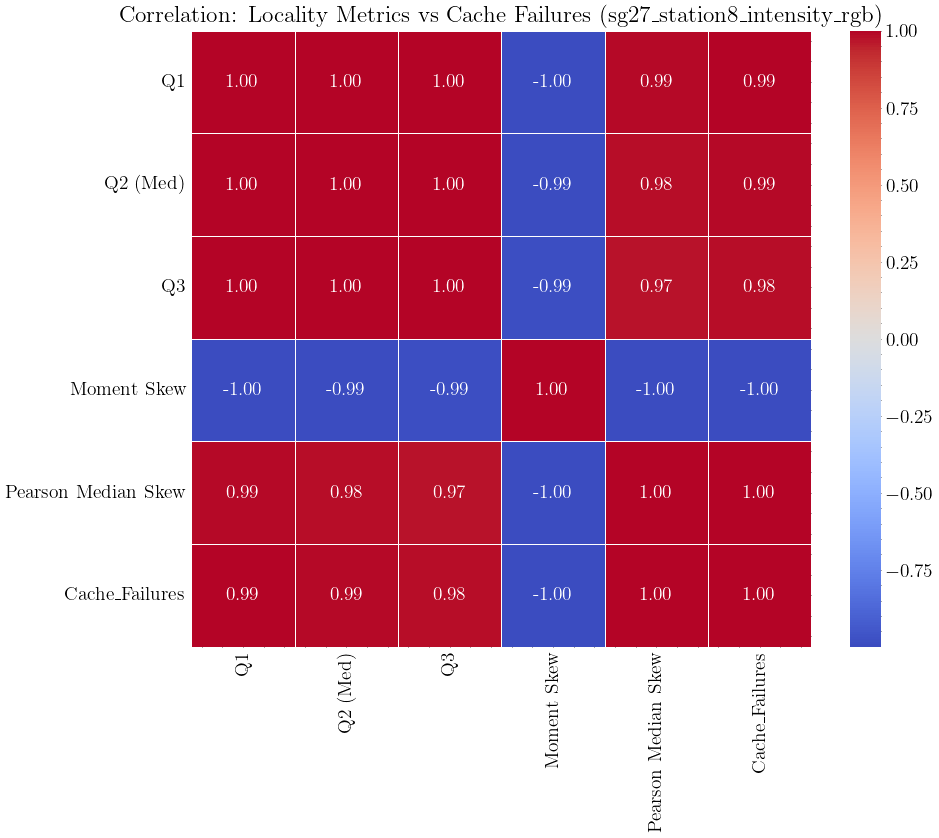

In [ ]:
K = 50
def show_visualizations(cloud, min_dist = 1000, percent_plotted=0.99, bin_size=10, use_log=False, kde=False):
    dfs = get_all_locality_files(BASE_DATA_PATH, cloud)
    original_dfs = {}
    for name, df in dfs.items():
        original_dfs[name] = df.copy()
    
    # Bin
    if bin_size > 1:
        dfs = bin_datasets(dfs, bin_size)

    # Compute right limits for each encoding at percent_plotted of distances seen
    per_datase_max_dists = compute_max_dists(dfs, percent=percent_plotted)
    print(f"Distance limits for {percent_plotted*100}% of counts per dataset:")
    for encoder, l in per_datase_max_dists.items():
        print(f"  {encoder}: {l}")

    # Use the maximum of all as final right limit for plotting
    max_dist = max(per_datase_max_dists.values())
    print(f"Using final plot limit = {max_dist}")

    # Filter the dfs in the range
    for key, df in dfs.items():
        dfs[key] = df[(df["distance"] >= min_dist) & (df["distance"] <= max_dist)]
    hist = plot_locality_hist(dfs, bin_size, min_dist, max_dist, K, use_log)
    hist3D = plot_locality_waterfall(dfs, bin_size, min_dist, max_dist, K, use_log)
    if kde:
        plot_locality_kde(dfs, min_dist, max_dist)
    return hist, hist3D

## Lille_0 (10M) y Paris_Luxembourg_7 (10M)
Dos de las tiles de paris_lille, aquí ya se empiezan a ver los picos en distancias alejadas que contribuyen a los fallos caché cuando no reordenas la nube.

../out/locality
Loading results file: ../out/locality/Lille_0/Lille_0-none-locality.csv
Loading results file: ../out/locality/Lille_0/Lille_0-mort-locality.csv
Loading results file: ../out/locality/Lille_0/Lille_0-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 496900
  mort: 199500
  hilb: 201100
Using final plot limit = 496900
Encoder         Q1   Q2 (Med)          Q3  Moment Skew  Pearson Median Skew
   none 43576.7739 81849.6658 144061.2687       1.8699               0.6347
   mort    13.2604    61.7288    322.0044      18.5887               0.2496
   hilb    10.0359    43.1391    248.2911      22.8253               0.2301


/home/pablo/pablo-diaz/.conda/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/pablo/pablo-diaz/.conda/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


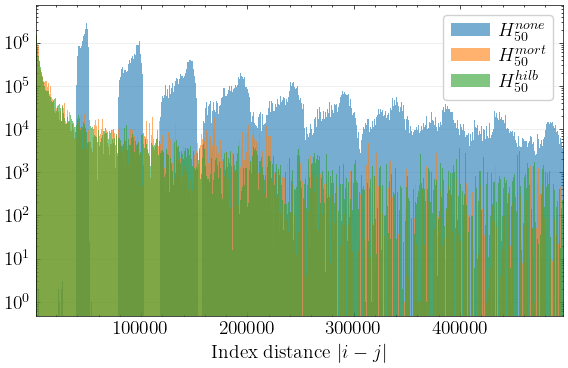

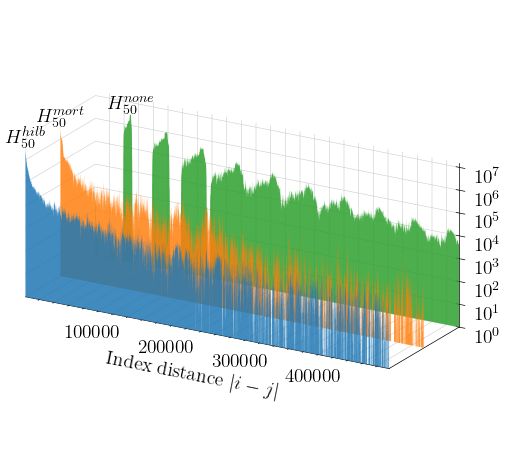

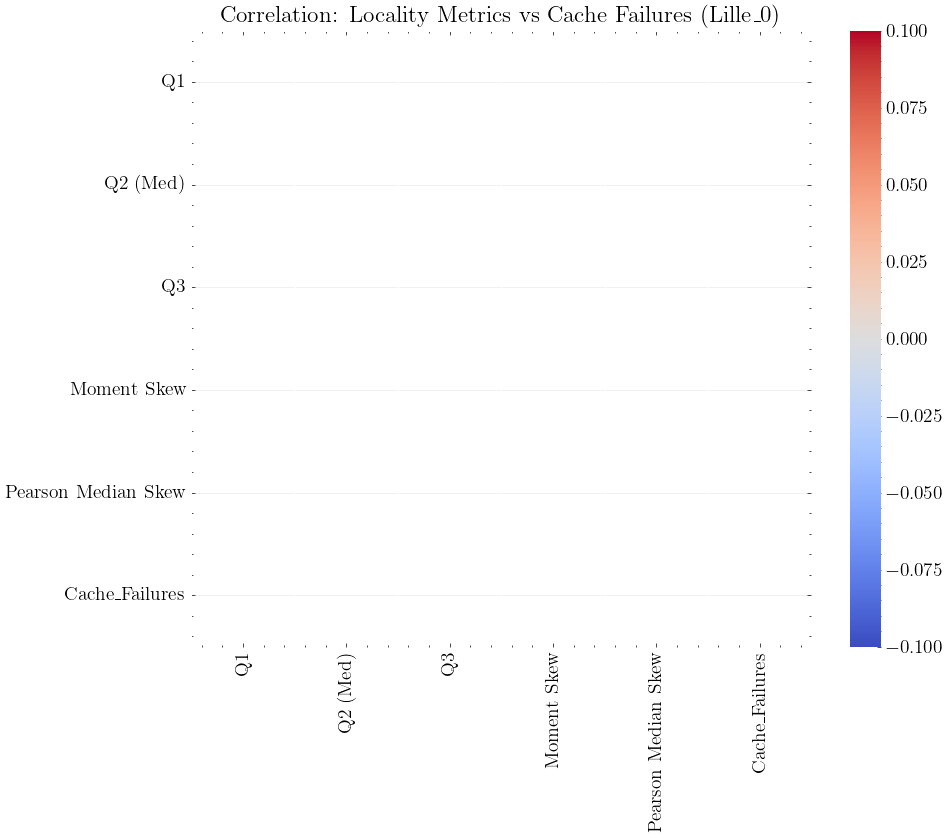

ValueError: too many values to unpack (expected 2)

In [45]:
hist, hist3D = show_visualizations("Lille_0", 1000, 0.99, 100, use_log=True)
output_fig(hist, OUTPUT_FOLDER, "fig_locality_Lille_0")
output_fig(hist3D, OUTPUT_FOLDER, "fig_locality_Lille_0_3d")
display(hist)
hist3D

## Lille full (120M)
El archivo de esta nube está creado con `lasmerge` de cada una de las partes `Lille_xx`. Imagino que los saltos grandes que se ven serán justo por eso, en las partes mal pegadas habrá una distancia enorme entre los puntos. Por lo que reordenar al juntar varias tiles de un dataset es muy importante.

Aquí uso $bin\_size = 1000$ y escala logarítmica en el eje Y del histograma para poder visualizar mejor

In [ ]:
# show_visualizations("Lille", 1000, 0.99, 1000, use_log=True)

## Paris_Luxembourg full (50M)

Aquí no observé los picos como en el de `Lille`, el resultado es parecido al de las tiles por separado

In [ ]:
# show_visualizations("Paris_Luxembourg", 1000, 0.99, 1000)

## Datasets Semantic3D

- bildstein_station1_xyz_intensity_rgb (29M puntos)
- sg27_station8_intensity_rgb (42M puntos)
- station1_xyz_intensity_rgb (50M puntos)

Tienen resultados variados, los de bildstein y sg27 no mejoran demasiado, mientras que el de station1 es mucho mejor tras reordenar.

In [ ]:
# show_visualizations("bildstein_station1_xyz_intensity_rgb", 1000, 0.99, 100)

../out/locality
Loading results file: ../out/locality/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-none-locality.csv
Loading results file: ../out/locality/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-mort-locality.csv
Loading results file: ../out/locality/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-hilb-locality.csv
Distance limits for 99.5% of counts per dataset:
  none: 631200
  mort: 111200
  hilb: 112700
Using final plot limit = 631200


/tmp/ipykernel_3335/1356309680.py:35: RuntimeWarning: overflow encountered in scalar multiply
  m3_skew = (np.sqrt(n * (n - 1)) / (n - 2)) * m3_skew


Encoder      Q1  Q2 (Med)       Q3  Moment Skew  Pearson Median Skew
   none 10.3571   38.5750 196.5258       1.0348               0.0870
   mort  7.1591   17.5954  49.1844       2.3724               0.0533
   hilb  7.1536   18.9557  61.9693       2.4816               0.0465


/home/pablo/pablo-diaz/.conda/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/pablo/pablo-diaz/.conda/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


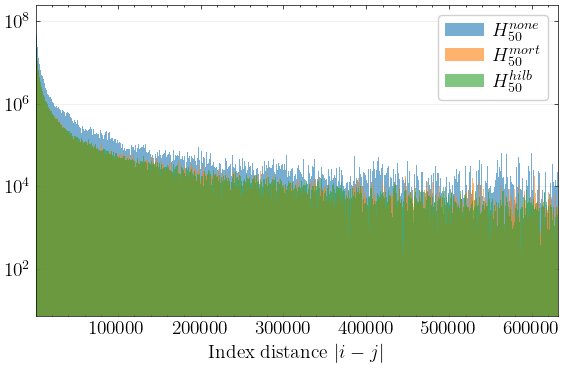

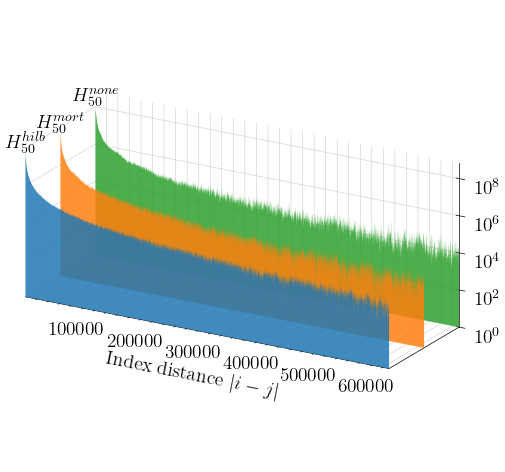

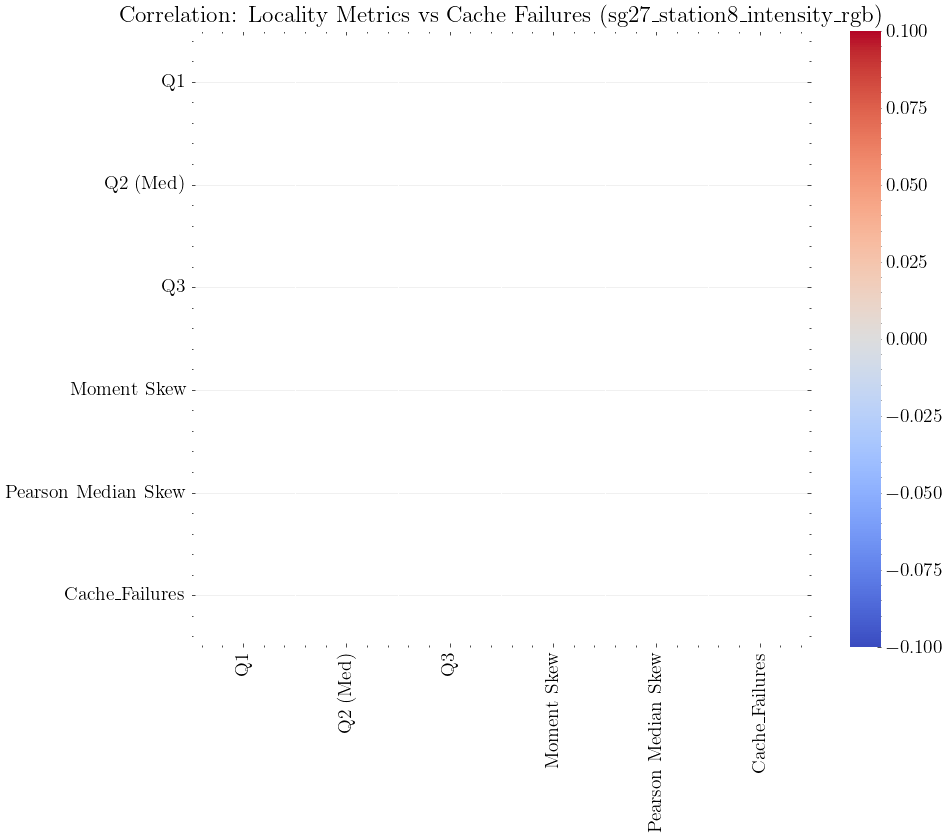

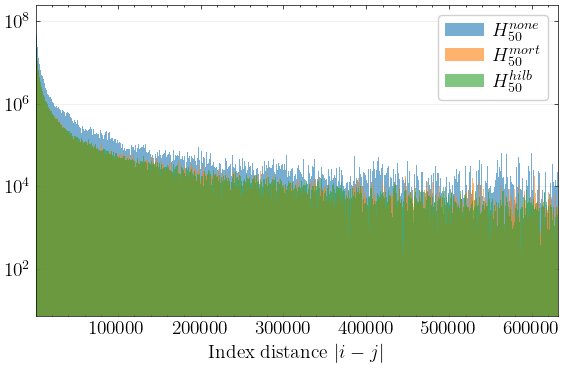

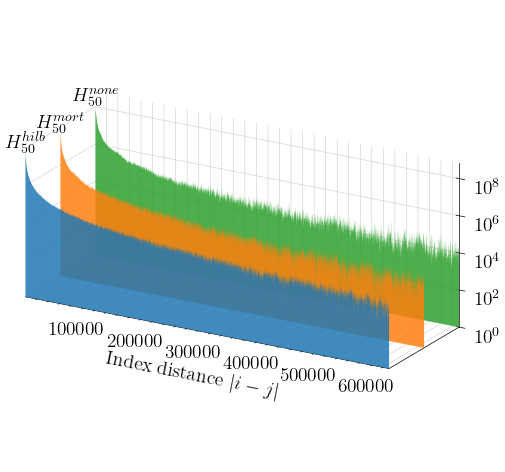

None

In [ ]:
hist, hist3D = show_visualizations("sg27_station8_intensity_rgb", 1000, 0.995, 100, use_log=True)
output_fig(hist, OUTPUT_FOLDER, "fig_locality_sg27")
output_fig(hist3D, OUTPUT_FOLDER, "fig_locality_sg27_3d")
display(hist)
display(hist3D)

../out/locality
Loading results file: ../out/locality/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-none-locality.csv
Loading results file: ../out/locality/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-mort-locality.csv
Loading results file: ../out/locality/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 33673000
  mort: 176000
  hilb: 165000
Using final plot limit = 33673000
Encoder      Q1  Q2 (Med)        Q3  Moment Skew  Pearson Median Skew
   none  9.5415   39.8918 1032.1492       1.8720               1.3932
   mort 10.1110   41.9735  195.6840      40.8537               0.1331
   hilb  8.7697   32.6895  165.7649      42.0903               0.1308


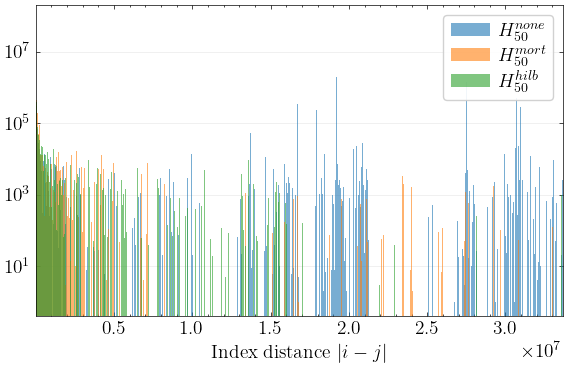

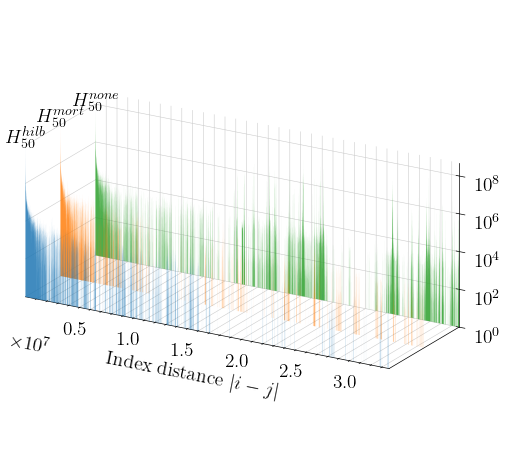

In [ ]:
hist, hist3D = show_visualizations("station1_xyz_intensity_rgb", 1000, 0.99, 1000, use_log=True)
output_fig(hist, OUTPUT_FOLDER, "fig_locality_station1")
output_fig(hist3D, OUTPUT_FOLDER, "fig_locality_station1_3d")
display(hist)
hist3D

## DALES

Dibujados en escala logarítmica porque se distingue mucho mejor. El hecho de que sea LiDAR aéreo imagino que influye a la mala localidad original.

../out/locality
Loading results file: ../out/locality/5080_54400/5080_54400-none-locality.csv
Loading results file: ../out/locality/5080_54400/5080_54400-mort-locality.csv
Loading results file: ../out/locality/5080_54400/5080_54400-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 11028500
  mort: 601500
  hilb: 494500
Using final plot limit = 11028500
Encoder           Q1     Q2 (Med)           Q3  Moment Skew  Pearson Median Skew
   none 1674881.7476 3328748.5025 6018326.0556       0.5567               0.6926
   mort      12.2451      56.5920     347.6283      16.3235               0.2783
   hilb       9.7679      42.0853     265.5359      19.2851               0.2930


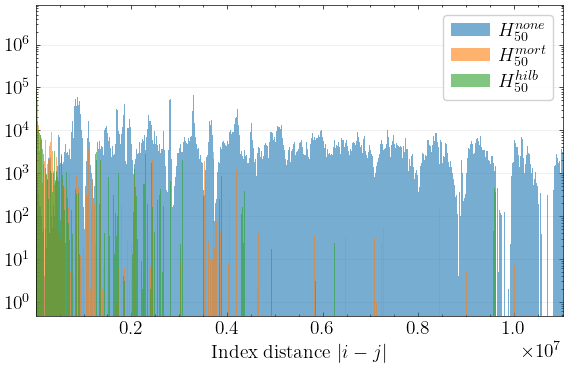

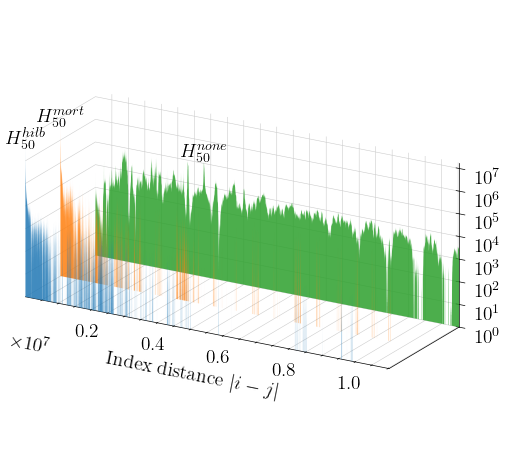

In [ ]:
hist, hist3D = show_visualizations("5080_54400", 1000, 0.99, 100, use_log = True)
output_fig(hist, OUTPUT_FOLDER, "fig_locality_5080_54400")
output_fig(hist3D, OUTPUT_FOLDER, "fig_locality_5080_54400_3d")
display(hist)
hist3D

In [ ]:
# show_visualizations("5140_54390", 1000, 0.99, 100, use_log = True)

In [ ]:
# show_visualizations("5150_54325", 1000, 0.99, 100, use_log = True)